In [19]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML

# Load the data using the tempeh package
from tempeh.configurations import datasets
dataset = datasets['adult_uci']()

X_train, X_test = dataset.get_X(format=pd.DataFrame)
A_train, A_test = X_train.get(key='Race'), X_test.get(key='Race')
X_train, X_test = X_train.drop(columns=['Race','Sex']), X_test.drop(columns=['Race','Sex'])

y_train, y_test = dataset.get_y(format=pd.Series)

# Combine all training data into a single data frame and glance at a few rows
all_train = pd.concat([X_train, y_train, A_train], axis=1)
display(all_train)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Capital Gain,Capital Loss,Hours per week,Country,y,Race
0,34.0,6.0,14.0,2.0,5.0,4.0,0.0,0.0,60.0,39.0,0,4.0
1,22.0,4.0,9.0,4.0,1.0,0.0,0.0,0.0,60.0,39.0,0,4.0
2,30.0,4.0,13.0,4.0,12.0,0.0,0.0,0.0,40.0,39.0,1,4.0
3,40.0,4.0,11.0,4.0,7.0,3.0,0.0,0.0,40.0,39.0,0,4.0
4,62.0,4.0,10.0,0.0,1.0,0.0,0.0,1974.0,40.0,39.0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
21810,55.0,1.0,9.0,2.0,4.0,4.0,0.0,0.0,40.0,39.0,0,4.0
21811,33.0,7.0,9.0,2.0,13.0,4.0,0.0,0.0,40.0,39.0,0,4.0
21812,19.0,6.0,9.0,4.0,3.0,3.0,0.0,0.0,40.0,39.0,0,4.0
21813,23.0,4.0,9.0,4.0,14.0,0.0,0.0,0.0,38.0,39.0,0,4.0


In [20]:
from sklearn.linear_model import LogisticRegression

unmitigated_predictor = LogisticRegression(solver='liblinear', fit_intercept=True)
unmitigated_predictor.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
from fairlearn.metrics import group_roc_auc_score

# a convenience function that transforms the result of a group metric call into a data frame
def group_metric_as_df(name, group_metric_result):
    a = pd.Series(group_metric_result.by_group)
    a['overall'] = group_metric_result.overall
    return pd.DataFrame({name: a})

scores_unmitigated = pd.Series(unmitigated_predictor.predict_proba(X_test)[:,1], name="score_unmitigated")
auc_unmitigated = group_metric_as_df("auc_unmitigated",
                                     group_roc_auc_score(y_test, scores_unmitigated, A_test))

display(HTML('<span id="auc_unmitigated">'),
        auc_unmitigated,
        HTML('</span>'))

,auc_unmitigated
0.0,0.790572
1.0,0.838235
2.0,0.898440
3.0,0.945130
4.0,0.871639
overall,0.874172


In [22]:
def get_error(y,predicted_y):
    correct_y = (y == predicted_y)
    return 1 - sum(correct_y)/len(correct_y)

In [23]:
unmitigated_y = pd.Series(unmitigated_predictor.predict(X_test),name="unmitigated_predicted_y")
error_unmitigated = [get_error(y_test,unmitigated_y)]
print("The error for unmitigated is:")
print(error_unmitigated)

The error for unmitigated is:
[0.1690861715987344]


In [24]:
def get_violation(predict_y,A_test,label_name):
    violations = []
    predicted_and_sensitiveFeature = pd.concat([predict_y,A_test],axis=1)
    grouped =predicted_and_sensitiveFeature.groupby('Race')
    counts_by_race = grouped[[label_name]].count()
    passed_by_race = grouped[[label_name]].sum()
#     display(counts_by_race)
#     display(passed_by_race)
    for i,group in enumerate(grouped.groups.keys()):
        violation_1 = passed_by_race[label_name][i] / counts_by_race[label_name][i]
        violation_2 = sum(predict_y) / len(predict_y)
        violations.append(abs(violation_1 - violation_2))
    violation = max(violations)
    return violation
    
violation_unmitigated = [get_violation(unmitigated_y,A_test,'unmitigated_predicted_y')]
print("The violation for unmitigated is:")
print(violation_unmitigated)

The violation for unmitigated is:
[0.09934892520899477]


In [25]:
class LeastSquaresBinaryClassifierLearner:
    def __init__(self):
        self.weights = None

    def fit(self, X, Y, sample_weight):
        sqrtW = np.sqrt(sample_weight)
        matX = np.array(X) * sqrtW[:, np.newaxis]
        vecY = Y * sqrtW
        self.lsqinfo = np.linalg.lstsq(matX, vecY, rcond=-1)
        self.weights = pd.Series(self.lsqinfo[0], index=list(X))

    def predict(self, X):
        pred = X.dot(np.asarray(self.weights))
        return 1 * (pred > 0.5)

In [26]:
# Eq-op violation is calculated as:
# max(abs(E[h(x) | A=a, Y=1] - E[h(x) | Y = 1]))
def get_eqop_violation(predict_y, A, Y, label_name):
    violations = []
    predicted_and_y_and_sensitive_feat = pd.concat([predict_y, Y, A],axis=1)
    grouped_y_and_sensitive_feat = predicted_and_y_and_sensitive_feat.groupby(
        [Y, 'Race'])
    pass_by_group = grouped_y_and_sensitive_feat[[label_name]].sum()
    counts_by_group = grouped_y_and_sensitive_feat[[label_name]].count()

    grouped_y = predicted_and_y_and_sensitive_feat.groupby(Y)
    pass_by_y = grouped_y[[label_name]].sum()
    counts_by_y = grouped_y[[label_name]].count()

    pos_prob = pass_by_y[label_name][1] / counts_by_y[label_name][1]
    neg_prob = pass_by_y[label_name][0] / counts_by_y[label_name][0]

    for key, item in enumerate(grouped_y_and_sensitive_feat.groups.keys()):
        if item[0] == 1:
            violation_2 = pos_prob
        if item[0] == 0:
            violation_2 = neg_prob
        if item[1] == 1:
            # E[h(x)| A = a, Y = 1]
            violation_1 = pass_by_group[label_name][item[0]][item[1]] / \
                         counts_by_group[label_name][item[0]][item[1]]

            violations.append(abs(violation_1 - violation_2))

    violation = max(violations)
    return violation

In [28]:
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch, TruePositiveRateDifference
import numpy as np
eps_list = [0.001,0.002,0.003,0.005,0.007,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
# eps_list = list(np.arange(0.001, 0.1, 0.001))
# eps_list = [0.01]
expgrad_error = []
expgrad_violation = []
estimator = LeastSquaresBinaryClassifierLearner()
for eps in eps_list:
    expgrad_X = ExponentiatedGradient(
    estimator,
    constraints=TruePositiveRateDifference(),
    eps=eps,
    nu=1e-6)
    
    expgrad_X.fit(
    X_train,
    y_train,
    sensitive_features=A_train)
    
    expgrad_y = pd.Series(expgrad_X.predict(X_train),name="expgrad_predicted_y")
    error_expgrad = get_error(y_train,expgrad_y)
    expgrad_error.append(error_expgrad)
    violation_expgrad = get_eqop_violation(expgrad_y,A_train,y_train,"expgrad_predicted_y")
    expgrad_violation.append(violation_expgrad)


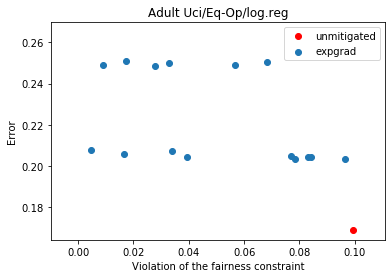

In [29]:
import matplotlib.pyplot as plt

plt.scatter(expgrad_violation,expgrad_error,label="expgrad")
plt.plot(violation_unmitigated,error_unmitigated,'ro',label="unmitigated")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/Eq-Op/log.reg')
plt.legend()
plt.show()